In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['trainoof', 'instant-gratification']


In [2]:
train = pd.read_csv('../input/instant-gratification/train.csv')
test = pd.read_csv('../input/instant-gratification/test.csv')

In [3]:
for i in range(3):
    # INITIALIZE VARIABLES
    cols = [c for c in train.columns if c not in ['id', 'target']]
    cols.remove('wheezy-copper-turtle-magic')
    oof = np.zeros(len(train))
    preds = np.zeros(len(test))

    # BUILD 512 SEPARATE MODELS
    for i in range(512):
        # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
        train2 = train[train['wheezy-copper-turtle-magic']==i]
        test2 = test[test['wheezy-copper-turtle-magic']==i]
        idx1 = train2.index; idx2 = test2.index
        train2.reset_index(drop=True,inplace=True)

        # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
        sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
        train3 = sel.transform(train2[cols])
        test3 = sel.transform(test2[cols])

        # STRATIFIED K-FOLD
        skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
        for train_index, test_index in skf.split(train3, train2['target']):

            # MODEL AND PREDICT WITH QDA
            clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
            clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
            oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
            preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

        #if i%64==0: print(i)

    # PRINT CV AUC
    auc = roc_auc_score(train['target'],oof)
    print('QDA scores CV = {}, iteration = {}'.format(round(auc,5), i))
    
    y = train['target'].copy()
    abs_dists = np.abs(oof-y)

    confs = np.argsort(abs_dists)[::-1]
    splitat = int(np.ceil(confs.shape[0] * 0.005)) #get the worse 5%
    wrongs = confs[:splitat]
    y_new = y.copy()
    y_new[wrongs] = 1- y[wrongs]
    train['target'] = y_new
    print("Number of flipped records = ",np.sum(y_new != y))

QDA scores CV = 0.96541, iteration = 511
Number of flipped records =  1311
QDA scores CV = 0.97513, iteration = 511
Number of flipped records =  1311
QDA scores CV = 0.98251, iteration = 511
Number of flipped records =  1311


In [4]:
import pickle

with open('../input/trainoof/prediction.pkl', 'rb') as f:
    vlads = pickle.load(f)

In [5]:
preds[0:131073] = vlads[0:131073]
test['target'] = preds
        
for i in range(3):
        # INITIALIZE VARIABLES
        oof = np.zeros(len(train))
        preds = np.zeros(len(test))
        t0, t1 = 0.01, 0.99

        # BUILD 512 SEPARATE MODELS
        for k in range(512):
            # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
            train0 = train[train['wheezy-copper-turtle-magic']==k] 
            idx1 = train0.index 
            test0 = test[test['wheezy-copper-turtle-magic']==k]


            t_index = test0.index   

            test0.reset_index(drop=True,inplace=True)



            # STRATIFIED K FOLD
            skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
            for train_index, test_index in skf.split(train0, train0['target']):

                x_train, x_valid = train0[cols].iloc[train_index], train0[cols].iloc[test_index]
                y_train, y_valid = train0['target'].iloc[train_index], train0['target'].iloc[test_index]

                sel = VarianceThreshold(threshold=3.6).fit(x_train)     
                x_train = sel.transform(x_train)
                x_test = sel.transform(test0[cols])
                x_valid = sel.transform(x_valid)


                test2p = pd.DataFrame(x_test)
                test2p['target'] = test0['target'].values
                test2p = test2p[(test0['target']<= t0) | (test0['target'] >= t1)]
                test2p.loc[test2p['target']>=0.5, 'target' ] = 1
                test2p.loc[test2p['target']<0.5, 'target' ] =  0 

                x_train = np.concatenate([x_train, test2p.drop(labels=['target'], axis=1).values])
                y_train = np.concatenate([y_train, test2p['target'].values])


                # MODEL AND PREDICT WITH QDA
                clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
                clf.fit(x_train, y_train)
                oof[idx1[test_index]] = clf.predict_proba(x_valid)[:,1]
                preds[t_index] += clf.predict_proba(x_test)[:,1] / skf.n_splits

            if k%64==0: print(k)

        # PRINT CV AUC
        auc = roc_auc_score(train['target'],oof)
        print('Pseudo Labeled QDA scores CV =',round(auc,5))
        
        y = train['target'].copy()
        abs_dists = np.abs(oof-y)

        confs = np.argsort(abs_dists)[::-1]
        splitat = int(np.ceil(confs.shape[0] * 0.005)) #get the worse 5%
        wrongs = confs[:splitat]
        y_new = y.copy()
        y_new[wrongs] = 1- y[wrongs]
        train['target'] = y_new
        print("Number of flipped records = ",np.sum(y_new != y))

0
64
128
192
256
320
384
448
Pseudo Labeled QDA scores CV = 0.98857
Number of flipped records =  1311
0
64
128
192
256
320
384
448
Pseudo Labeled QDA scores CV = 0.99214
Number of flipped records =  1311
0
64
128
192
256
320
384
448
Pseudo Labeled QDA scores CV = 0.99424
Number of flipped records =  1311


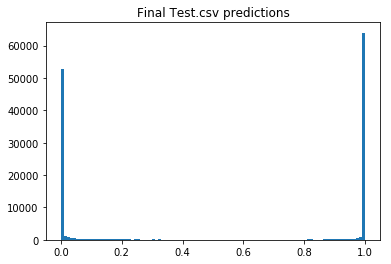

In [6]:
sub = pd.read_csv('../input/instant-gratification/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()